# Predicting COVID-19 cases based on US mask usage

Sahil Narkhede, Michael Rashkov and Gauri Sharma

##### Description:
###### We are going to use Big Query’s publically available data on number of covid cases in US Counties on a daily basis and mask preferences of each county. We also plan to use the population, land area and political affiliation of each county. The goal is to merge all these tables and better understand which factors affect Covid-19 cases

##### Source: 
###### NYTimes mask wearing dataset. 
###### US County Covid Cases:  https://console.cloud.google.com/bigquery?authuser=1&organizationId=935399055473&project=gs-is843&p=bigquery-public-data&d=covid19_nyt&page=dataset
###### Land Area: https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html#LND
###### Population: https://www.census.gov/programs-surveys/popest/data/data-sets.html
###### Political: https://github.com/tonmcg/US_County_Level_Election_Results_08-20/blob/master/2020_US_County_Level_Presidential_Results.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.types import StructField, StructType, StringType, LongType, DoubleType, FloatType
from pyspark.sql.functions import col, isnan, when, count, col, udf
from pyspark.sql import functions as F 
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.classification import LogisticRegression

data = "gs://is843-project-team4/notebooks/jupyter/data/" 

For this project we used multiple datasets from different sources. The next few cells will focus on importing all the data and merging it together on County FIPS Code to create a final dataframe.

In [2]:
#import US mask use data
myManualSchema1 = StructType([
  StructField("county_fips_code", LongType(), True),
  StructField("never", DoubleType(), True),
  StructField("rarely", DoubleType(), True),
  StructField("sometimes", DoubleType(), True),
  StructField("frequently", DoubleType(), True),
  StructField("always", DoubleType(), True)
])

df_mask = spark.read.format("csv")\
  .schema(myManualSchema1)\
  .option("header", "true")\
  .option("nullValue", "NA")\
  .load(data + "mask_use_by_county.csv")

df_mask.show(2)

+----------------+-----+------+---------+----------+------+
|county_fips_code|never|rarely|sometimes|frequently|always|
+----------------+-----+------+---------+----------+------+
|           15007|  0.0| 0.021|    0.046|     0.108| 0.825|
|           36011|  0.0| 0.033|    0.072|     0.162| 0.732|
+----------------+-----+------+---------+----------+------+
only showing top 2 rows



In [3]:
#check that all the percentages add up to 1
df_mask = df_mask.withColumn("sum", col("never") + col("rarely") + col("sometimes") + col("frequently") + col("always"))
#show all the columns that don't add up to 1
df_mask.where((col("sum") < 0.995) & (col("sum") > 1)).show()
#drop the column since all probabilities add up to 1
df_mask = df_mask.drop("sum")

+----------------+-----+------+---------+----------+------+---+
|county_fips_code|never|rarely|sometimes|frequently|always|sum|
+----------------+-----+------+---------+----------+------+---+
+----------------+-----+------+---------+----------+------+---+



In [4]:
#import US COVID-19 cases by county data
myManualSchema2 = StructType([
  StructField("date", StringType(), True),
  StructField("county", StringType(), True),
  StructField("state_name", StringType(), True),
  StructField("county_fips_code", LongType(), True),
  StructField("confirmed_cases", LongType(), True),
  StructField("deaths", LongType(), True)
])

df = spark.read.format("csv")\
  .schema(myManualSchema2)\
  .option("header", "true")\
  .option("nullValue", "NA")\
  .load(data + "us_counties.csv")

df = df.withColumnRenamed("county", "county_name")
df.show(2)

+----------+-----------+----------+----------------+---------------+------+
|      date|county_name|state_name|county_fips_code|confirmed_cases|deaths|
+----------+-----------+----------+----------------+---------------+------+
|2020-07-30|     Apache|   Arizona|            4001|           2969|   129|
|2020-07-30|    Cochise|   Arizona|            4003|           1467|    47|
+----------+-----------+----------+----------------+---------------+------+
only showing top 2 rows



In [5]:
#aggregate the time series data by maximum cases and deaths
df_cases = df.groupBy("county_fips_code","county_name","state_name").agg({"confirmed_cases":"max", "deaths":"max"}) 
df_cases = df_cases.withColumnRenamed("max(confirmed_cases)", "cases").withColumnRenamed("max(deaths)", "deaths")
#df_cases.show(5)

In [6]:
#load in census population data
df_pop = spark.read.format("csv")\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .option("nullValue", "NA")\
  .load(data + "us_county_pop.csv")

#limit to only columns of interest
df_pop = df_pop.select("state", "county", "stname", "ctyname", "popestimate2019")
df_pop.show(2)

+-----+------+-------+--------------+---------------+
|state|county| stname|       ctyname|popestimate2019|
+-----+------+-------+--------------+---------------+
|    1|     0|Alabama|       Alabama|        4903185|
|    1|     1|Alabama|Autauga County|          55869|
+-----+------+-------+--------------+---------------+
only showing top 2 rows



In [7]:
#create fips code column since this data set doesn't have that column
df_pop_new = df_pop.withColumn("fips", \
                    F.when( (F.length(df_pop.county) < 2) & (F.length(df_pop.state) < 2), \
                    F.concat(df_pop.state, F.lit(0), F.lit(0), df_pop.county)) \
                                              
                    .when( (F.length(df_pop.county) == 2) & (F.length(df_pop.state) == 2), \
                    F.concat(df_pop.state, F.lit(0), df_pop.county))  
                                              
                    .when( (F.length(df_pop.county) == 2) & (F.length(df_pop.state) < 2), \
                    F.concat(df_pop.state, F.lit(0), df_pop.county))
                    
                     .when( (F.length(df_pop.county) < 2) & (F.length(df_pop.state) == 2), \
                    F.concat(df_pop.state, F.lit(0), F.lit(0), df_pop.county))

                    .otherwise(F.concat(df_pop.state, df_pop.county)))
df_pop_new.show(2)

+-----+------+-------+--------------+---------------+----+
|state|county| stname|       ctyname|popestimate2019|fips|
+-----+------+-------+--------------+---------------+----+
|    1|     0|Alabama|       Alabama|        4903185|1000|
|    1|     1|Alabama|Autauga County|          55869|1001|
+-----+------+-------+--------------+---------------+----+
only showing top 2 rows



In [8]:
#load land data
df_land = spark.read.format("csv")\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .option("nullValue", "NA")\
  .load(data + "land_area.csv")
df_land = df_land.select("STCOU", "LND010190D").withColumnRenamed("LND010190D","land_area")
df_land.show(2)

+-----+----------+
|STCOU| land_area|
+-----+----------+
|    0|3787425.08|
| 1000|  52422.94|
+-----+----------+
only showing top 2 rows



In [9]:
#load political data
df_pol = spark.read.format("csv")\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .option("nullValue", "NA")\
  .load(data + "US_County_Level_Presidential_Results.csv")
df_pol.show(2)

+----------+-----------+--------------+---------+---------+-----------+-----+------------------+-------------------+------------------+
|state_name|county_fips|   county_name|votes_gop|votes_dem|total_votes| diff|           per_gop|            per_dem|    per_point_diff|
+----------+-----------+--------------+---------+---------+-----------+-----+------------------+-------------------+------------------+
|   Alabama|       1001|Autauga County|    19838|     7503|      27770|12335| 0.714368023046453|0.27018365142239825|0.4441843716240547|
|   Alabama|       1003|Baldwin County|    83544|    24578|     109679|58966|0.7617137282433283|0.22409029987509005|0.5376234283682382|
+----------+-----------+--------------+---------+---------+-----------+-----+------------------+-------------------+------------------+
only showing top 2 rows



In [10]:
#create binary column of demo (1) or rep (0)
df_pol = df_pol.withColumn("party_dem", \
                    F.when(df_pol.votes_dem > df_pol.votes_gop, 1) \
                    .otherwise(0))
df_pol = df_pol.select("county_fips", "party_dem")
df_pol.show(5)

+-----------+---------+
|county_fips|party_dem|
+-----------+---------+
|       1001|        0|
|       1003|        0|
|       1005|        0|
|       1007|        0|
|       1009|        0|
+-----------+---------+
only showing top 5 rows



In [11]:
#merge all the datasets using fips code
df_merge = df_cases.join(df_mask, df_mask.county_fips_code==df_cases.county_fips_code, how="left").drop(df_mask.county_fips_code)
df_merge = df_merge.join(df_pop_new, df_merge.county_fips_code==df_pop_new.fips, how="left").drop("fips", "state", "county", "stname","ctyname")
df_merge = df_merge.join(df_land, df_merge.county_fips_code==df_land.STCOU, how="left").drop("STCOU")
df_merge = df_merge.join(df_pol, df_merge.county_fips_code==df_pol.county_fips, how="left").drop("county_fips")
df_merge.toPandas().head() 

,county_fips_code,county_name,state_name,cases,deaths,never,rarely,sometimes,frequently,always,popestimate2019,land_area,party_dem
0,39095.0,Lucas,Ohio,36254,767.0,0.078,0.056,0.111,0.189,0.566,428348.0,560.64,1.0
1,49015.0,Emery,Utah,852,9.0,0.122,0.109,0.106,0.239,0.424,10012.0,4461.83,0.0
2,48489.0,Willacy,Texas,2494,82.0,0.034,0.015,0.067,0.064,0.820,21358.0,784.27,1.0
3,41001.0,Baker,Oregon,687,11.0,0.051,0.189,0.179,0.189,0.392,16124.0,3088.61,0.0
4,13079.0,Crawford,Georgia,630,17.0,0.057,0.051,0.231,0.192,0.468,12404.0,326.48,0.0


Using the above data frame, we created 4 new columns:

1. Population Density = Population / Land Area
2. Cases per capita = #Cases / Population
3. Deaths per capita = #Deaths / Population 
4. Mask Use Index = 0 * never + 0 * rarely + 1 * sometimes + 2 * frequently + 3 * always

Mask Use Index naively puts more weight into `always` followed by `frequently` and `sometimes` and zero weight into `never` and `rarely`. Thus, counties that have higher population always wearing a mask have a higher mask use index

In [12]:
#create population density, cases per capita, deaths per capita, mask use index
df_new = df_merge.withColumn("pop_density", col("popestimate2019")/col("land_area"))
df_new = df_new.withColumn("cases_per_capita", col("cases")/col("popestimate2019"))
df_new = df_new.withColumn("deaths_per_capita", col("deaths")/col("popestimate2019"))
df_new = df_new.withColumn("mask_use_index", (0 * col("never")) + (0 * col("rarely")) + (1 * col("sometimes")) + (2 * col("frequently")) + (3 * col("always")))

df_new = df_new.drop("land_area", "popestimate2019") #drop land area and population
df_new.toPandas().head()

,county_fips_code,county_name,state_name,cases,deaths,never,rarely,sometimes,frequently,always,party_dem,pop_density,cases_per_capita,deaths_per_capita,mask_use_index
0,39095.0,Lucas,Ohio,36254,767.0,0.078,0.056,0.111,0.189,0.566,1.0,764.033961,0.084637,0.001791,2.187
1,49015.0,Emery,Utah,852,9.0,0.122,0.109,0.106,0.239,0.424,0.0,2.243922,0.085098,0.000899,1.856
2,48489.0,Willacy,Texas,2494,82.0,0.034,0.015,0.067,0.064,0.820,1.0,27.232968,0.116771,0.003839,2.655
3,41001.0,Baker,Oregon,687,11.0,0.051,0.189,0.179,0.189,0.392,0.0,5.220471,0.042607,0.000682,1.733
4,13079.0,Crawford,Georgia,630,17.0,0.057,0.051,0.231,0.192,0.468,0.0,37.993139,0.050790,0.001371,2.019


In [13]:
#check for null/nan values in each column
df_new.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_new.columns]).show()

+----------------+-----------+----------+-----+------+-----+------+---------+----------+------+---------+-----------+----------------+-----------------+--------------+
|county_fips_code|county_name|state_name|cases|deaths|never|rarely|sometimes|frequently|always|party_dem|pop_density|cases_per_capita|deaths_per_capita|mask_use_index|
+----------------+-----------+----------+-----+------+-----+------+---------+----------+------+---------+-----------+----------------+-----------------+--------------+
|              56|          0|         0|    0|    78|  141|   141|      141|       141|   141|      167|        147|             141|              141|           141|
+----------------+-----------+----------+-----+------+-----+------+---------+----------+------+---------+-----------+----------------+-----------------+--------------+



In [14]:
#remove all the rows with nulls
df_final = df_new.filter(df_new.party_dem. isNotNull())
df_final = df_final.filter(df_final.pop_density. isNotNull())
#check for nulls again
df_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_final.columns]).show()

+----------------+-----------+----------+-----+------+-----+------+---------+----------+------+---------+-----------+----------------+-----------------+--------------+
|county_fips_code|county_name|state_name|cases|deaths|never|rarely|sometimes|frequently|always|party_dem|pop_density|cases_per_capita|deaths_per_capita|mask_use_index|
+----------------+-----------+----------+-----+------+-----+------+---------+----------+------+---------+-----------+----------------+-----------------+--------------+
|               0|          0|         0|    0|     0|    0|     0|        0|         0|     0|        0|          0|               0|                0|             0|
+----------------+-----------+----------+-----+------+-----+------+---------+----------+------+---------+-----------+----------------+-----------------+--------------+



In [15]:
df_final_pd = df_final.orderBy("state_name").toPandas()
df_final_pd.head() #final data set

,county_fips_code,county_name,state_name,cases,deaths,never,rarely,sometimes,frequently,always,party_dem,pop_density,cases_per_capita,deaths_per_capita,mask_use_index
0,1007,Bibb,Alabama,2475,60,0.020,0.034,0.096,0.278,0.572,0,35.801759,0.110521,0.002679,2.368
1,1041,Crenshaw,Alabama,1484,55,0.060,0.091,0.199,0.233,0.416,0,22.543419,0.107755,0.003994,1.913
2,1045,Dale,Alabama,4701,108,0.089,0.113,0.118,0.220,0.460,0,87.382713,0.095603,0.002196,1.938
3,1083,Limestone,Alabama,9476,142,0.102,0.034,0.133,0.336,0.395,0,162.924957,0.095799,0.001436,1.990
4,1043,Cullman,Alabama,9054,183,0.130,0.024,0.249,0.217,0.379,0,110.971571,0.108084,0.002185,1.820


# Exploartory Data Analysis

In [16]:
#convert to statewise data for plots
df_1 = df_merge.na.drop()
df_state = df_1.groupBy("state_name").agg(
    F.sum(F.col("cases")).alias("cases"), F.sum(F.col("deaths")).alias("deaths"), F.sum(F.col("popestimate2019")).alias("population"),
    F.sum(F.col("land_area")).alias("area"), F.avg(F.col("party_dem")).alias("party_dem"), 
    F.avg(F.col("never")).alias("never"), F.avg(F.col("rarely")).alias("rarely"), F.avg(F.col("sometimes")).alias("sometimes"), 
    F.avg(F.col("frequently")).alias("frequently"), F.avg(F.col("always")).alias("always")).orderBy("state_name")
    
df_state = df_state.withColumn("pop_density", col("population")/col("area"))
df_state = df_state.withColumn("cases_per_capita", col("cases")/col("population"))
df_state = df_state.withColumn("deaths_per_capita", col("deaths")/col("population"))
df_state = df_state.withColumn("ratio", col("deaths")/col("cases"))
df_state = df_state.withColumn("mask_use_index", (0 * col("never")) + (0 * col("rarely")) + (1 * col("sometimes")) + (2 * col("frequently")) + (3 * col("always")))
df_state = df_state.drop("area", "population")
df_state_pd = df_state.toPandas()
df_state_pd

,state_name,cases,deaths,party_dem,never,rarely,sometimes,frequently,always,pop_density,cases_per_capita,deaths_per_capita,ratio,mask_use_index
0,Alabama,502726,10305,0.194030,0.081567,0.081090,0.146612,0.215343,0.475313,93.531286,0.102530,0.002102,0.020498,2.003239
1,Arizona,832119,16520,0.333333,0.049667,0.053200,0.094667,0.147333,0.655000,63.844889,0.114322,0.002270,0.019853,2.354333
2,Arkansas,323288,5514,0.106667,0.090920,0.087253,0.138360,0.220627,0.462867,56.744476,0.107127,0.001827,0.017056,1.968213
3,California,3616878,55339,0.603448,0.032310,0.030724,0.063690,0.158603,0.714638,241.359221,0.091538,0.001401,0.015300,2.524810
4,Colorado,443843,6127,0.375000,0.039156,0.071937,0.097266,0.244328,0.547437,55.319100,0.077073,0.001064,0.013804,2.228234
5,Connecticut,289571,7755,0.750000,0.017500,0.023000,0.053625,0.126375,0.779500,643.132208,0.081220,0.002175,0.026781,2.644875
6,Delaware,89712,1496,0.666667,0.019333,0.006667,0.060667,0.095667,0.817667,391.168850,0.092129,0.001536,0.016676,2.705000
7,District of Columbia,42282,1038,1.000000,0.012000,0.013000,0.069000,0.164000,0.743000,10324.005266,0.059911,0.001471,0.024549,2.626000
8,Florida,1964352,32172,0.179104,0.055254,0.057522,0.110343,0.194299,0.582552,326.617509,0.091460,0.001498,0.016378,2.246597
9,Georgia,1003118,17626,0.188679,0.083333,0.078377,0.126145,0.199792,0.512314,178.620573,0.094478,0.001660,0.017571,2.062673


<Figure size 432x288 with 0 Axes>

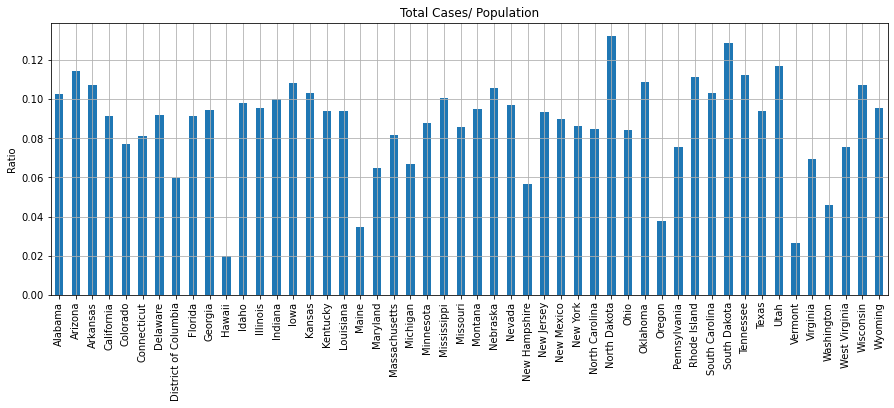

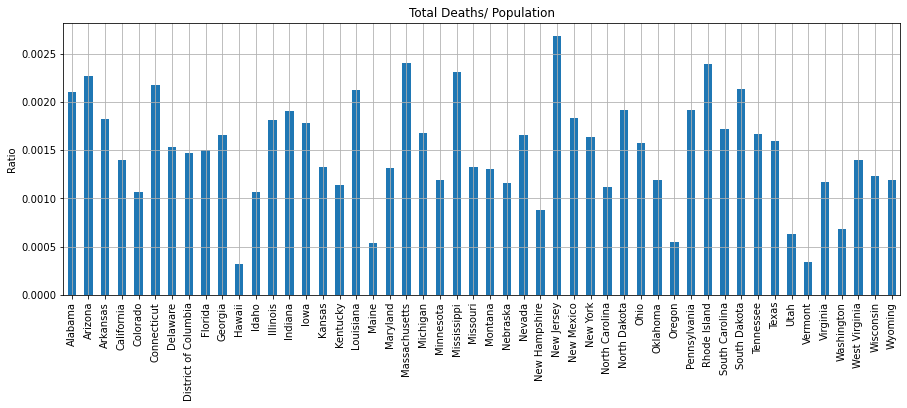

<Figure size 432x288 with 0 Axes>

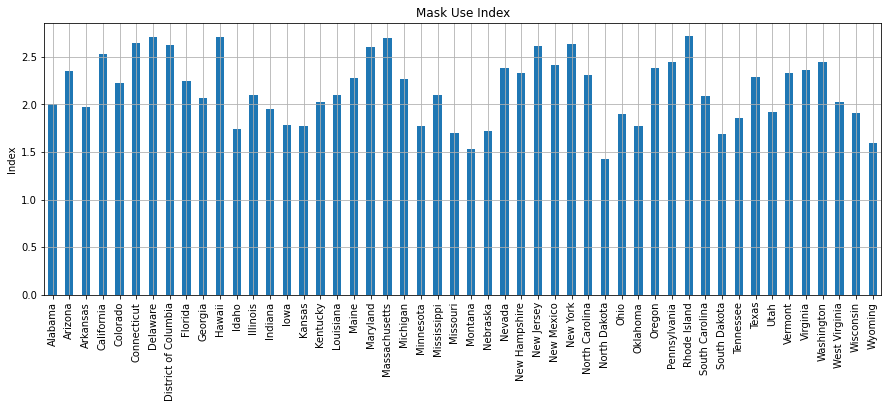

In [17]:
#plot total cases/population by state
plt.figure(1)
df_state_pd.plot("state_name", "cases_per_capita", figsize=(15,5), grid=True, legend=None, kind="bar")
plt.xticks(range(0,len(df_state_pd.index)), df_state_pd["state_name"]); plt.xticks(rotation = 90);
plt.title("Total Cases/ Population"); plt.ylabel("Ratio"); plt.xlabel("");

#plot total deaths/population by state
plt.figure(2)
df_state_pd.plot("state_name", "deaths_per_capita", figsize=(15,5), grid=True, legend=None, kind="bar")
plt.xticks(range(0,len(df_state_pd.index)), df_state_pd["state_name"]); plt.xticks(rotation = 90);
plt.title("Total Deaths/ Population"); plt.ylabel("Ratio"); plt.xlabel("");

#plot mask use index by state
plt.figure(4)
df_state_pd.plot("state_name", "mask_use_index", figsize=(15,5), grid=True, legend=None, kind="bar")
plt.xticks(range(0,len(df_state_pd.index)), df_state_pd["state_name"]); plt.xticks(rotation = 90);
plt.title("Mask Use Index"); plt.ylabel("Index"); plt.xlabel("");

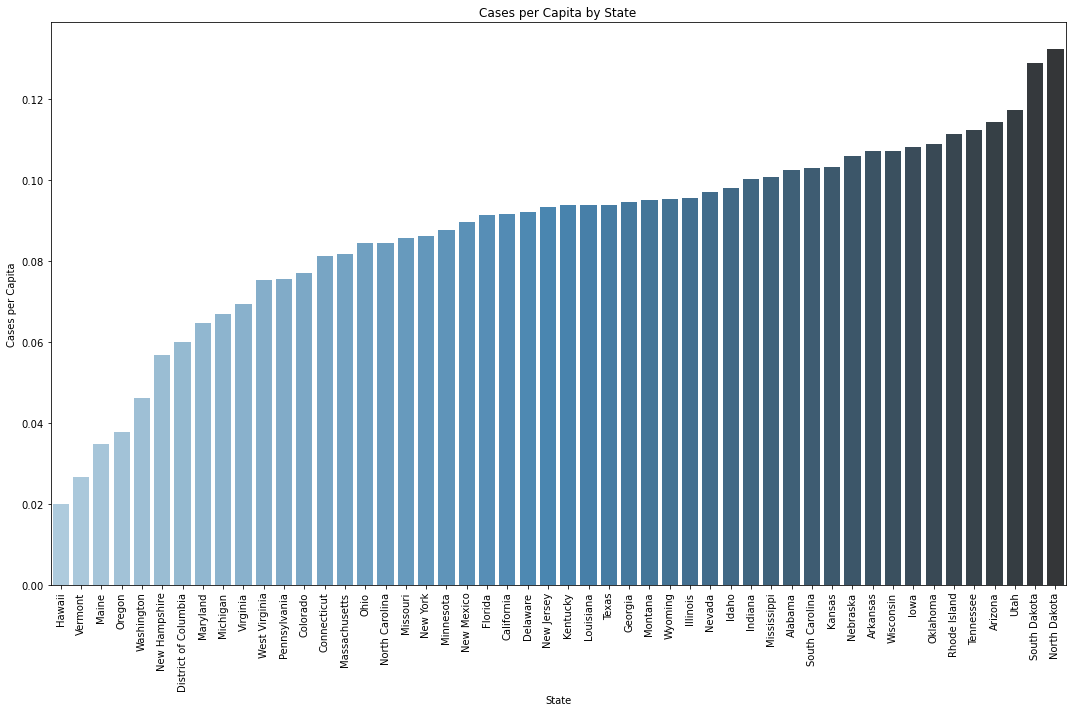

In [18]:
# Cases Per Capita per State
data_mean_sorted = df_state_pd.sort_values(['cases_per_capita']).reset_index()
plt.figure(figsize=(15, 10))
ax = sns.barplot(x="state_name", y="cases_per_capita", palette="Blues_d", data=data_mean_sorted)
plt.xlabel("State"); plt.ylabel("Cases per Capita"); plt.title("Cases per Capita by State"); plt.xticks(rotation=90)
plt.tight_layout()

We can see there is a lot of variablity in cases and deaths as well as mask use index between the different states. 
##### Intuitive Results across states in terms of covid cases and mask usage:
Hawaii has one of the highest mask usage and has the lowest cases and deaths per capita. 
North Dakota on the other hand has low mask use index and high cases and deaths per capita.

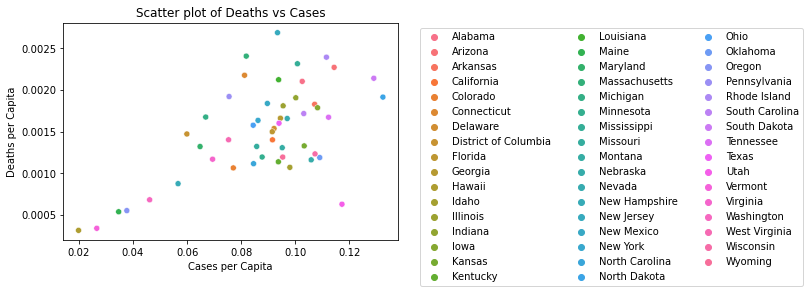

In [19]:
# Scatterplot of Cases Per Capita vs Deaths Per Capita vs State
f, ax = plt.subplots()
sns.scatterplot(x="cases_per_capita", y="deaths_per_capita", hue="state_name", data=df_state_pd, ax=ax);
handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1.05, 1), ncol=3, loc=0);
ax.set_xlabel("Cases per Capita"); ax.set_ylabel("Deaths per Capita");
ax.set_title("Scatter plot of Deaths vs Cases");

There is a positive correlation between cases and deaths per capita. For states with higher values of cases per capita, there is more variability in deaths per capita. This might be related to state level covid restrictions. 

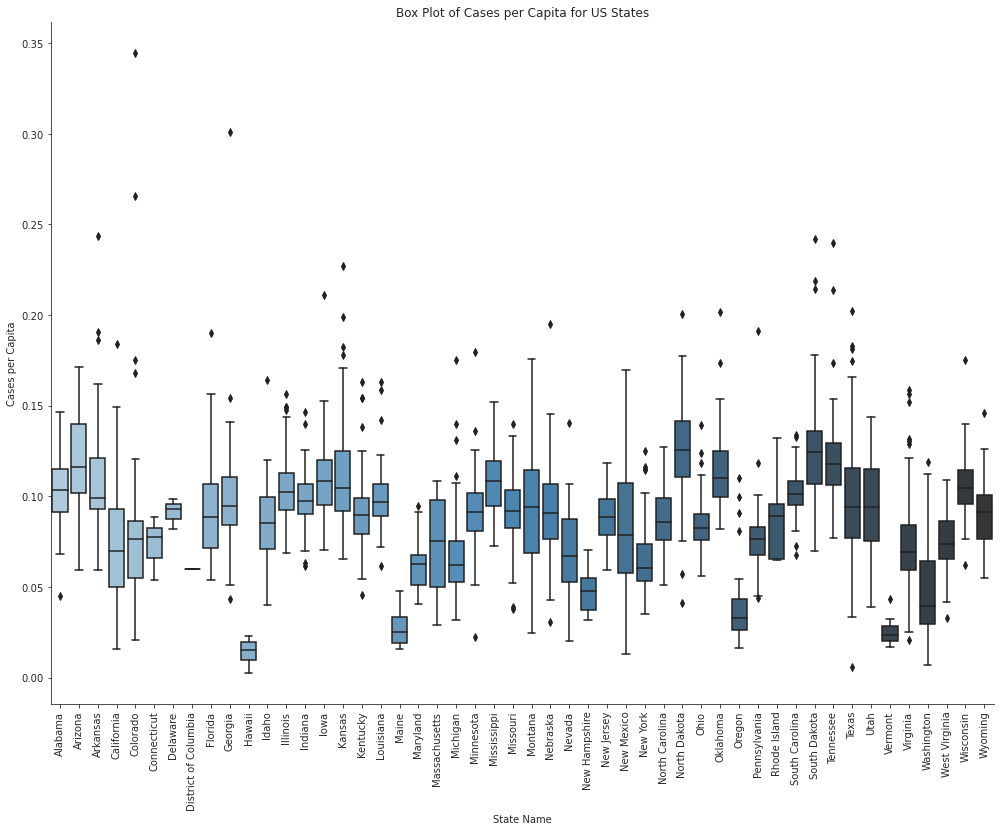

In [20]:
# Catplot of Cases Per Capita vs State (for all counties within a state)
sns.set_style("ticks")
ax = sns.catplot(x="state_name", y="cases_per_capita", kind="box", data=df_final_pd, palette="Blues_d", height=10, aspect=1.4);
ax.set_xticklabels(rotation=90);
plt.xlabel("State Name"); plt.ylabel("Cases per Capita");
plt.title("Box Plot of Cases per Capita for US States");

This plot allows us to see the different quantiles and outliers for each state. County level outbreaks seem to be happening across the country.

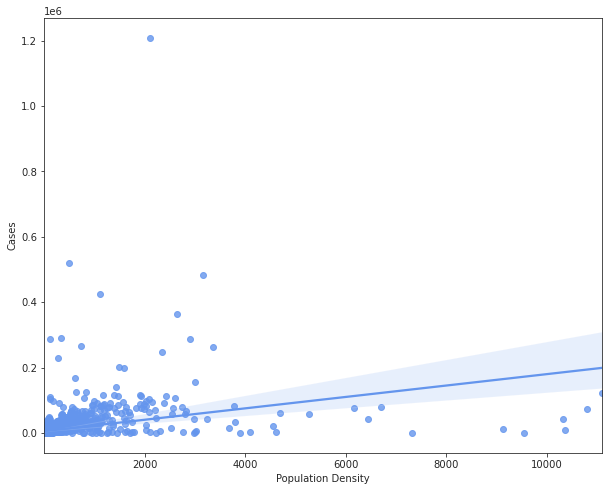

In [21]:
# Scatterplot of Population Density vs Cases
plt.figure(figsize=(10,8))
sns.regplot(x='pop_density', y='cases', data=df_final_pd, color="cornflowerblue");
plt.xlabel("Population Density"); plt.ylabel("Cases");

Ther is a positive relationship between cases and population density

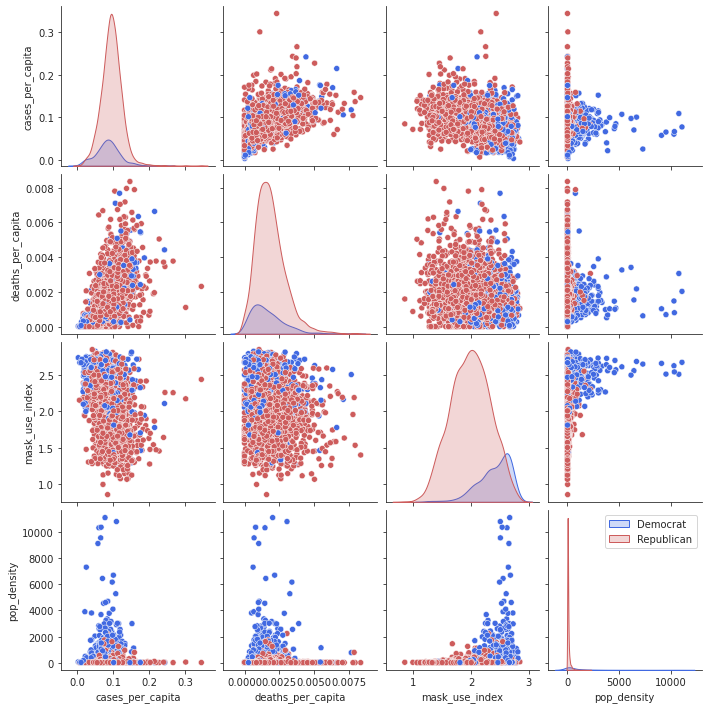

In [22]:
# Create a pairplot of select variables in seaborn
colors = ["indianred", "royalblue"]
sns.set_palette(sns.color_palette(colors))
data_abbreviated = df_final_pd[["cases_per_capita", "deaths_per_capita", "mask_use_index", "pop_density", "party_dem"]]
g = sns.pairplot(data_abbreviated, hue="party_dem");
g._legend.remove()
plt.legend(labels=['Democrat', 'Republican'])
plt.show(g)

Mask Use Index is higher for Democrat counties.
We observe that different counties seem to be clustered based on political affiliation.

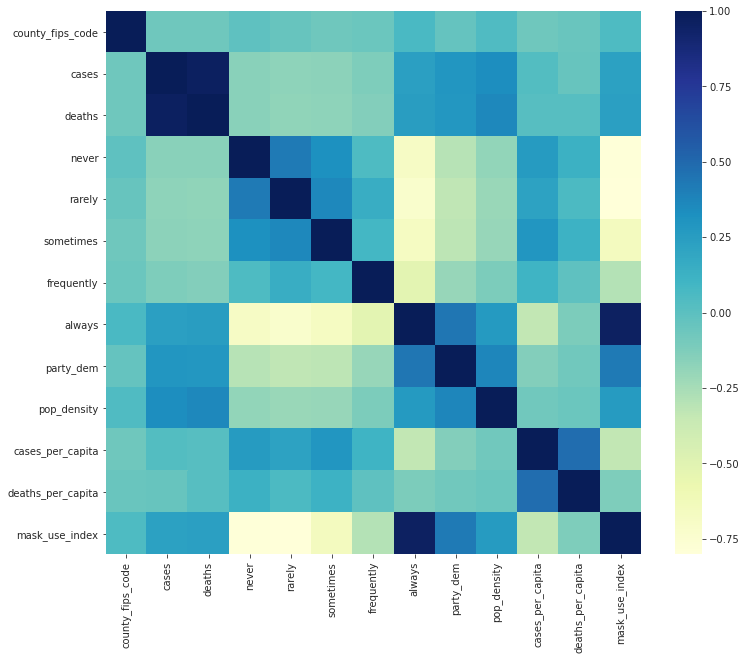

In [23]:
# Heatmap of the correlations
plt.figure(figsize = (12, 10));
sns.heatmap(df_final_pd.corr(), annot=False, fmt=".2f", cmap="YlGnBu", cbar=True);

Heatmap helps us visualize the correlations between the different varaibles

<Figure size 360x360 with 0 Axes>

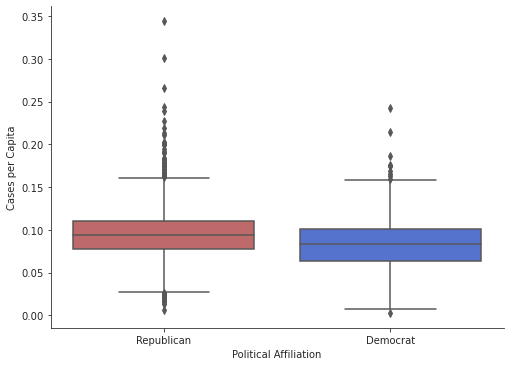

In [24]:
# Boxplot of Party Affiliation vs Cases Per Capita 
plt.figure(figsize=(5,5));
sns.catplot(x="party_dem", y="cases_per_capita", kind="box", data=df_final_pd, aspect=1.4);
plt.xlabel("Political Affiliation"); plt.ylabel("Cases per Capita"); plt.xticks([0,1], ["Republican", "Democrat"]);

Across all counties, Republican counties have slightly higher cases per capita and more variability especially at the higher levels of cases per capita

# KMeans Clustering
We are going to use population density, number of cases per capita, mask use index and poilitical affiliation to assign each county to a cluster.  

In [25]:
cluster_data = df_final.select("county_fips_code", "pop_density", "cases_per_capita", "mask_use_index", "party_dem")
cluster_data.show(2)

+----------------+------------------+-------------------+------------------+---------+
|county_fips_code|       pop_density|   cases_per_capita|    mask_use_index|party_dem|
+----------------+------------------+-------------------+------------------+---------+
|           39095| 764.0339611872147|0.08463679064685722|             2.187|        1|
|           49015|2.2439223367990264|0.08509788254095085|1.8559999999999999|        0|
+----------------+------------------+-------------------+------------------+---------+
only showing top 2 rows



In [26]:
#assemble the data into features and scale using a pipeline
assemble=VectorAssembler(inputCols=["pop_density", "cases_per_capita", "mask_use_index", "party_dem"], outputCol='features')
scale=StandardScaler(inputCol='features',outputCol='standardized')
pipeline = Pipeline(stages=[assemble, scale])

#fit to the pipeline
data_scale_output=pipeline.fit(cluster_data).transform(cluster_data)
data_scale_output.show(2)

+----------------+------------------+-------------------+------------------+---------+--------------------+--------------------+
|county_fips_code|       pop_density|   cases_per_capita|    mask_use_index|party_dem|            features|        standardized|
+----------------+------------------+-------------------+------------------+---------+--------------------+--------------------+
|           39095| 764.0339611872147|0.08463679064685722|             2.187|        1|[764.033961187214...|[1.17088322508927...|
|           49015|2.2439223367990264|0.08509788254095085|1.8559999999999999|        0|[2.24392233679902...|[0.00343881444547...|
+----------------+------------------+-------------------+------------------+---------+--------------------+--------------------+
only showing top 2 rows



In [27]:
#PCA to reduce dimensionality 
pca = PCA(k=2, inputCol="standardized", outputCol="pca")
model = pca.fit(data_scale_output)
transformed = model.transform(data_scale_output)

In [28]:
# Trains a k-means model.
kmeans = KMeans(k=15, seed=843)
model = kmeans.fit(transformed)

# Make predictions
predictions = model.transform(transformed)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7739951830539243


In [29]:
# View cluster centres
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[88.85065054  0.0903033   2.08066069  0.10313901]
[3.85086603e+03 6.26734004e-02 2.55880000e+00 1.00000000e+00]
[1.06479692e+04 7.78690761e-02 2.58725000e+00 1.00000000e+00]
[2.09585364e+03 8.88567969e-02 2.44439130e+00 9.56521739e-01]
[6.43536642e+03 8.89364036e-02 2.58000000e+00 1.00000000e+00]
[1.51590168e+03 8.06838897e-02 2.50657576e+00 8.78787879e-01]
[4.02644950e+02 8.56513641e-02 2.33032237e+00 3.55263158e-01]
[2.11449375e+02 8.87864961e-02 2.22843866e+00 2.11895911e-01]
[6.81152570e+02 8.90478114e-02 2.38341096e+00 5.89041096e-01]
[1.04902349e+03 8.91787286e-02 2.47875000e+00 7.88461538e-01]
[2.86737729e+03 8.90533110e-02 2.53805556e+00 1.00000000e+00]
[21.8391259   0.09541908  1.9541586   0.10016694]
[4.78034275e+03 8.56149151e-02 2.60325000e+00 1.00000000e+00]
[7.30850000e+03 2.49025108e-02 2.64900000e+00 1.00000000e+00]
[9.33532512e+03 6.10653510e-02 2.58500000e+00 1.00000000e+00]


In [30]:
print("Number of counties in each cluster", model.summary.clusterSizes)

Number of counties in each cluster [669, 5, 4, 23, 3, 33, 152, 268, 73, 52, 18, 1798, 4, 1, 2]


In [31]:
#visualize the clusters
firstElement=udf(lambda v:float(v[0]),FloatType())
secondElement=udf(lambda v:float(v[1]),FloatType())
kMeansDf = predictions.select('*', firstElement('pca'), secondElement('pca')).toPandas()
kMeansDf.columns = ['county_fips_code', 'pop_density', 'cases_per_capita', 'mask_use_index', 'party_dem', 'features', 'standardized', 'pca', 'prediction', 'pc1', 'pc2']

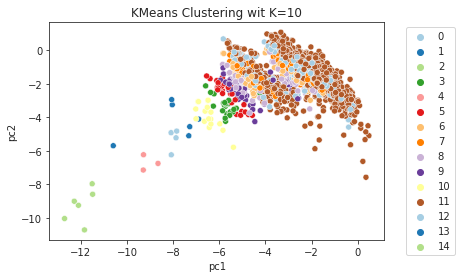

In [32]:
sns.scatterplot(data=kMeansDf, x='pc1', y='pc2', hue='prediction', palette="Paired");
plt.title("KMeans Clustering wit K=10");
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

KMeans Clustering identified 15 homogenous groups of counties based on similarities between the data.

# Linear Regression
##### Goal: predict the number of COVID-19 cases at the county level. Data updated as of March 2021. 

In [16]:
df_final = df_final.select('cases', 'mask_use_index', 
                          'deaths','party_dem', 'pop_density').na.drop()

Before running the regression model, we assemble the feature columns and standardize them. Also the data is split into 80% training set and 20% test set.

In [34]:
#Create vector of features and scale them
vectorAssembler = VectorAssembler(inputCols = ['mask_use_index', 'deaths','party_dem', 'pop_density'], outputCol = 'features')
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

pipeline = Pipeline(stages=[vectorAssembler, scaler])
scaledData = pipeline.fit(df_final).transform(df_final)
scaledData.show(5)

+-----+------------------+------+---------+------------------+--------------------+--------------------+
|cases|    mask_use_index|deaths|party_dem|       pop_density|            features|      scaledFeatures|
+-----+------------------+------+---------+------------------+--------------------+--------------------+
|36254|             2.187|   767|        1| 764.0339611872147|[2.187,767.0,1.0,...|[5.97610387003302...|
|  852|1.8559999999999999|     9|        0|2.2439223367990264|[1.85599999999999...|[5.07162724407009...|
| 2494|             2.655|    82|        1|27.232968237979268|[2.655,82.0,1.0,2...|[7.25494091218000...|
|  687|             1.733|    11|        0|5.2204713447149365|[1.733,11.0,0.0,5...|[4.73552263683915...|
|  630|             2.019|    17|        0| 37.99313893653516|[2.019,17.0,0.0,3...|[5.51703416259564...|
+-----+------------------+------+---------+------------------+--------------------+--------------------+
only showing top 5 rows



In [35]:
# Prepare training and test data.
vector_df = scaledData.withColumnRenamed('cases', 'label')
train, test = vector_df.randomSplit([0.8, 0.2], seed=12345)

We use `ParamGridBuilder` and `TrainValidationSplit` to tune the hyperparameters (regularization and net elastic regularization parameter) of the Linear Regression.  

In [36]:
#instantiate linear model
lr = LinearRegression(labelCol="label", featuresCol="scaledFeatures", maxIter=10)

# Conduct a grid search to identify best parameters
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

#instantiate evaluator
evaluator=RegressionEvaluator()

#specify model parameters
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
tvs_model = tvs.fit(train)

# Make predictions on test data. Model is the model with combination of parameters
# that performed best.
tvs_lrpredictions_train = tvs_model.transform(train)\
    .select("scaledFeatures", "label", "prediction")

tvs_lrpredictions = tvs_model.transform(test)\
    .select("scaledFeatures", "label", "prediction")

In [37]:
# performance R2 and RMSE
print('R2 train:', evaluator.setMetricName('r2').evaluate(tvs_lrpredictions_train))
print('R2 test:', evaluator.setMetricName('r2').evaluate(tvs_lrpredictions))
print('RMSE train:', evaluator.setMetricName('rmse').evaluate(tvs_lrpredictions_train))
print('RMSE test:', evaluator.setMetricName('rmse').evaluate(tvs_lrpredictions))

R2 train: 0.9493504932868935
R2 test: 0.8302478495227845
RMSE train: 8104.542379476187
RMSE test: 9001.2704474498


In [38]:
train.describe().show()

+-------+-----------------+-------------------+-----------------+-------------------+------------------+
|summary|            label|     mask_use_index|           deaths|          party_dem|       pop_density|
+-------+-----------------+-------------------+-----------------+-------------------+------------------+
|  count|             2494|               2494|             2494|               2494|              2494|
|   mean|9268.985164394548| 2.0551816359262225|164.4366479550922|0.16800320769847635|186.94641787814476|
| stddev|36018.69492639541|0.36652263811594804|649.4827821213682| 0.3739441109905864| 608.7293706894512|
|    min|                1|              0.852|                0|                  0|0.2076480263157895|
|    max|          1208678|              2.849|            22304|                  1|11102.214746285394|
+-------+-----------------+-------------------+-----------------+-------------------+------------------+



In [39]:
#check coeffcients of features
print('Intercept: ', tvs_model.bestModel.intercept, "\n",
     'coefficients: ', tvs_model.bestModel.coefficients)

Intercept:  0.0 
 coefficients:  [34.69426115640216,32597.081643232952,217.19346416717016,-282.0162315660268]


##### Conclusion 
Even though we get a high R2 of ~96% on trainning data and ~80 on test data, the RMSE (Root Mean Squared Error) is extremely high ~11000. Since mean of cases is ~8000, RMSE of ~11000 makes the model extremely unstable and weak. 

Conclusion: It appears as if our data is not great at predicting Covid 19 cases. We could potentially investigate adding additional features for next steps or perhaps running a time series model to get a more accurate presentation of Covid-19 cases.

# Logistic Regression
##### Goal: Classify County as Democratic or Republican based on Covid Statistics and Mask Use Index

In [18]:
df_final = df_final.withColumnRenamed('party_dem', 'label')

In [21]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="label ~ .")
fittedRF = supervised.fit(df_final)
preparedDF = fittedRF.transform(df_final)

train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)

lr = LogisticRegression()
lrModel = lr.fit(train)

In [22]:
plt.rcParams["figure.figsize"] = (8,6)

In [24]:
summary = lrModel.summary
print("AUC:", summary.areaUnderROC)

AUC: 0.8591025956346663


Train AUC: 0.8591025956346663


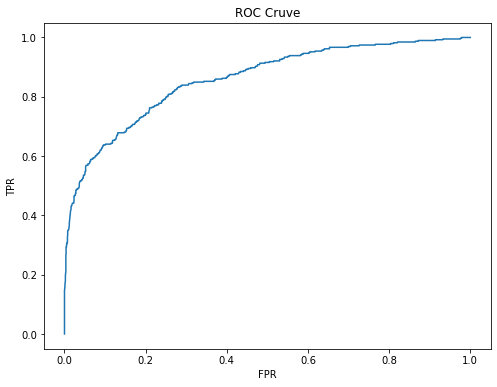

In [26]:
roc = summary.roc.toPandas()
roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Cruve')
plt.ylabel('TPR')

print('Train AUC:', summary.areaUnderROC)

In [27]:
fittedTest = lrModel.transform(test)

In [28]:
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

In [30]:
print('Test AUC:', aucEvaluator.evaluate(fittedTest))

Test AUC: 0.826896614158971


In [32]:
lrModel.coefficients

DenseVector([0.0, 3.5046, -0.0002, 0.0019])

In [33]:
train.show(2)

+-----+------------------+------+-----+------------------+--------------------+
|cases|    mask_use_index|deaths|label|       pop_density|            features|
+-----+------------------+------+-----+------------------+--------------------+
|   12|             1.475|     1|    0|0.2909112631044473|[12.0,1.475,1.0,0...|
|   33|2.5919999999999996|     2|    0|0.2076480263157895|[33.0,2.591999999...|
+-----+------------------+------+-----+------------------+--------------------+
only showing top 2 rows



Conclusion: This model appears to be better. The AUCs are above 80% and nearly identifcal for the test and training data meaning the model is generalizable. Also it is evident from the coefficients that mask usage is the strongest predictor for political affiliation out of all the given features